In [1]:
import findspark
findspark.init('C:/applications/spark/spark-3.2.4-bin-hadoop2.7')

In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import time

import pyspark # only run this after findspark.init()
from pyspark.sql import SparkSession, SQLContext
from pyspark.context import SparkContext
from pyspark.sql.functions import * 
from pyspark.sql.types import * 

In [3]:
# Initiate the Spark Session
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [5]:
df = spark.read.csv("C:/Users/sonpal/Downloads/HR_Analytics.csv",header=True,inferSchema=True)

In [6]:
df.printSchema()

root
 |-- EmpID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- SalarySlab: string (nullable = true)
 |-- MonthlyRate: integer (nullable 

## Calculate the PowerBI Dashboard API

**1. Employee Count**

Count the number of employee in the Organization

In [7]:
emp_count = df.count()

In [8]:
print(f"Number of employee in the Organization: {emp_count}")

Number of employee in the Organization: 1480


**2. Attrition Count**

No. of employee left the organization

In [9]:
attrition_count = df.filter(col("Attrition") == True).count()

In [10]:
print(f"Number of employee left the organization: {attrition_count}")

Number of employee left the organization: 238


**3. Attrition Rate**

% rate of attrition

In [11]:
attri_rate = np.round((attrition_count/emp_count)*100,1)

In [12]:
print(f"Attrition Rate of the organization: {attri_rate}")

Attrition Rate of the organization: 16.1


**4. Avg. age of emp**

In [13]:
sum_of_attrition_emp_Age = df.filter(col("Attrition")==True).agg({"Age": "sum"}).collect()[0][0]

In [14]:
sum_of_attrition_emp_Age

8015

In [15]:
Avg_Age = np.round((sum_of_attrition_emp_Age/attrition_count),1)

In [16]:
print(f"Avg age of attrition Emp : {Avg_Age} year")

Avg age of attrition Emp : 33.7 year


**5. Avg. Salary of Attri. Emp.**

In [17]:
# sum of employee salary those are left the organization
total_salary = df.filter(col("Attrition")==True).agg({"MonthlyIncome":"sum"}).collect()[0][0]

In [18]:
avg_Salary = np.round((total_salary/attrition_count)/1000,1)

In [19]:
print(f"Avg salary of attrition Emp : {avg_Salary}k")

Avg salary of attrition Emp : 4.8k


**6. Avg. year**

what is the avg year of attrition employee work

In [20]:
total_year = df.filter(col("Attrition")==True).agg({"YearsAtCompany":"sum"}).collect()[0][0]
total_year

1219

In [21]:
# spark_sql
df.createOrReplaceTempView("employee_data")

# Execute a Spark SQL query to calculate the sum of "YearsAtCompany" where "Attrition" is true
result = spark.sql("SELECT SUM(YearsAtCompany) as total_year FROM employee_data WHERE Attrition = true")
result.collect()[0][0]

1219

In [22]:
# average year attrition emp work
avg_year = np.round((total_year/attrition_count),1)
print(f"Average year attrition emp work: {avg_year} year")

Average year attrition emp work: 5.1 year


**7. visualize graph show the attrition year wise**

In [23]:
grouped_df = df.filter(col('Attrition')==True).groupby('YearsAtCompany').count().orderBy(desc('YearsAtCompany'))

In [24]:
new_df = grouped_df.select('YearsAtCompany', 'count').withColumnRenamed('count', 'rowCount')

In [25]:
new_data = new_df.orderBy(asc('YearsAtCompany')).limit(11)

In [26]:
final_data = new_data.select('YearsAtCompany','rowCount').withColumnRenamed('rowCount','count')

In [27]:
final_data.show()

+--------------+-----+
|YearsAtCompany|count|
+--------------+-----+
|             0|   16|
|             1|   59|
|             2|   27|
|             3|   21|
|             4|   19|
|             5|   21|
|             6|    9|
|             7|   11|
|             8|    9|
|             9|    8|
|            10|   18|
+--------------+-----+



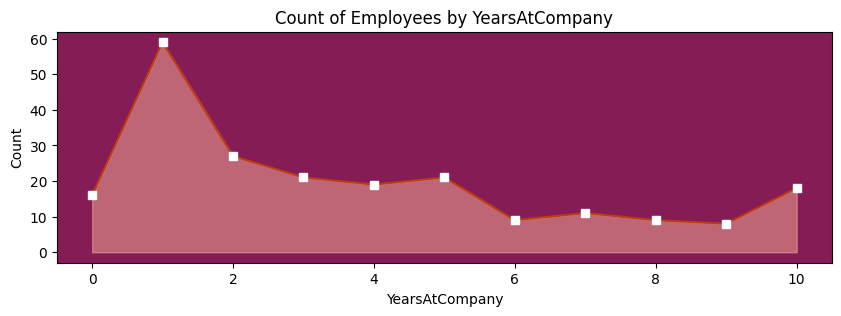

In [28]:
pandas_df = final_data.toPandas()

import matplotlib.pyplot as plt
# Sort Pandas DataFrame by 'YearsAtCompany'
pandas_df = pandas_df.sort_values(by='YearsAtCompany')
line_color = (189/255, 60/255, 17/255)
area_color = (247/255, 175/255, 151/255,0.5)
background_color = (133/255, 28/255, 85/255)
# Plotting
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_facecolor(background_color)
#plt.figure(figsize=(10, 3))
plt.plot(pandas_df['YearsAtCompany'], pandas_df['count'], marker='s',mfc='white',mec='white', linestyle='-', color=line_color)
plt.fill_between(pandas_df['YearsAtCompany'], pandas_df['count'], color=area_color)
plt.title('Count of Employees by YearsAtCompany')
plt.xlabel('YearsAtCompany')
plt.ylabel('Count')
plt.show()

**8. show the graph attrition basis on Department**

In [29]:
dept_df = df.filter(col('Attrition')==True).groupby('EducationField').count()

In [30]:
new_dept = dept_df.select('EducationField','count').withColumnRenamed('EducationField','Department')

In [31]:
new_dept.show()

+----------------+-----+
|      Department|count|
+----------------+-----+
|Technical Degree|   32|
|           Other|   11|
|       Marketing|   36|
|         Medical|   63|
|   Life Sciences|   89|
| Human Resources|    7|
+----------------+-----+



In [32]:
dept_pd = new_dept.toPandas()
dept_pd.head()

,Department,count
0,Technical Degree,32
1,Other,11
2,Marketing,36
3,Medical,63
4,Life Sciences,89


C:\Users\sonpal\AppData\Local\Temp\ipykernel_5492\2060693767.py:9: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  centre_circle = plt.Circle((0, 0), 0.2, color='white', edgecolor='black', linewidth=0.8)


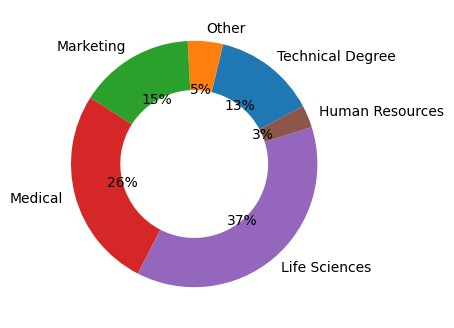

In [33]:
# Plotting a donut chart
plt.figure(figsize=(4, 4))

# Outer ring (Donut)
plt.pie(dept_pd['count'], labels=dept_pd['Department'], autopct='%1.0f%%', startangle=28,
        wedgeprops=dict(width=0.4))

# Inner circle (White center)
centre_circle = plt.Circle((0, 0), 0.2, color='white', edgecolor='black', linewidth=0.8)
plt.gca().add_artist(centre_circle)
plt.show()

**9. Attrition By Salary show using graph**

In [34]:
sal_df = df.filter(col('Attrition')==True).orderBy('MonthlyIncome')

In [35]:
new_sal = sal_df.select('MonthlyIncome').withColumnRenamed('MonthlyIncome','salary')

In [36]:
sal_pd = new_sal.toPandas()

In [37]:
bins = [0, 5000, 10000, 15000, float('inf')]
labels = ['Below 5k', '5k to 10k', '10k to 15k', '15k+']

# Add a new column 'salary_range' to the DataFrame based on the salary bins
sal_pd['salary_range'] = pd.cut(sal_pd['salary'], bins=bins, labels=labels, right=False)

# Count the number of data points in each salary range
count_by_range = sal_pd['salary_range'].value_counts().sort_index()

# Display the result
print(count_by_range)

salary_range
Below 5k      163
5k to 10k      49
10k to 15k     21
15k+            5
Name: count, dtype: int64


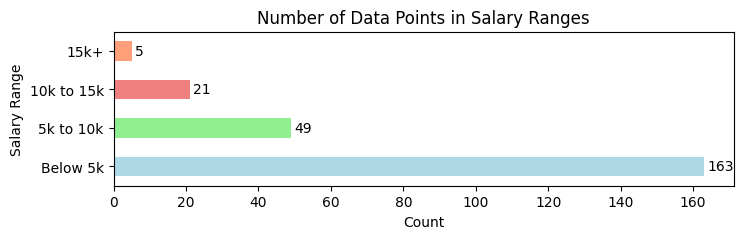

In [41]:
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']

plt.figure(figsize=(8, 2))
count_by_range.plot(kind='barh', color=colors)
plt.title('Number of Data Points in Salary Ranges')
plt.xlabel('Count')
plt.ylabel('Salary Range')


# Display count values on each bar
for i, count in enumerate(count_by_range):
    plt.text(count + 1, i, str(count), va='center')

plt.show()